In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil
from IPython import display

import meep as mp

import sys
sys.path.append('../../lib')
from ataitmeep import *

from lightlab.util import io
from lightlab.util.data import Spectrum, FunctionBundle, MeasuredFunction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
io.dataHome /= 'couplers'

In [7]:
# Define the system
# parameters for 1220nm

default_geometry = dict(
                        device_height = 0.22,
                        pitch = 0.6,
                        duty = 0.5,
                        post_diameter = 2,
                        n_periods = 10,
                        box_height = 2,
                        cladding_height = 2,
                        handle_height = 3,
                       )

oxide = mp.Medium(epsilon=2.25)
silicon = mp.Medium(epsilon=12)
air = mp.Medium(epsilon=1)

def give_cell(**kwargs):
    geom_dict = default_geometry.copy()
    geom_dict.update(kwargs)
    geo = objview(**geom_dict)

    cell = mp.Vector3(2 * geo.pitch * geo.n_periods + 5, geo.box_height + geo.cladding_height + 2*geo.handle_height)
    return cell

def give_geometry(**kwargs):
    geom_dict = default_geometry.copy()
    geom_dict.update(kwargs)
    geo = objview(**geom_dict)
    
    cladding = mp.Block(mp.Vector3(cell.x, geo.box_height + geo.cladding_height, 1e20),
                        center=mp.Vector3(0, 0),
                        material=oxide)
    handle = mp.Block(mp.Vector3(cell.x, geo.handle_height, 1e20),
                     center=mp.Vector3(0, -cell.y/2 + geo.handle_height/2),
                     material=silicon)
    space = mp.Block(mp.Vector3(cell.x, geo.handle_height, 1e20),
                     center=mp.Vector3(0, cell.y/2 - geo.handle_height/2),
                     material=air)
    device_layer = [mp.Block(mp.Vector3(geo.post_diameter, geo.device_height, 1e20),
                                        center=mp.Vector3(0, geo.device_height/2),
                                        material=silicon),
                   ]
    for iPeriod in range(geo.n_periods):
        for side_sign in [-1, 1]:
            device_layer.append(mp.Block(mp.Vector3(geo.pitch * geo.duty, geo.device_height, 1e20),
                                         center=mp.Vector3(side_sign * (geo.pitch * iPeriod + geo.pitch*1.5), geo.device_height/2),
                                         material=silicon))
    geometry = [cladding, handle, space]
    geometry.extend(device_layer)
    return geometry

cell = give_cell()
geometry = give_geometry()
    
dpml = 1.
pml_layers = [mp.PML(dpml)]

# this should be replaced by an eigenmode
fcen = 1 / 1.22
df = fcen / 10
nfreq = 101
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), 
                     component=mp.Ez,
                     center=mp.Vector3(0, default_geometry['device_height']/2), 
#                      size=mp.Vector3(0, sm_width),
                    ),
          ]
# sources = [mp.Source(mp.ContinuousSource(frequency=fcen, width=2),
#                      component=mp.Ez,
#                      center=mp.Vector3(-cell.x / 2 + dpml, 0),
# #                      center=mp.Vector3(cell.x / 2 - dpml, out_pitch / 2),  # not working
#                      size=mp.Vector3(0, sm_width))]

resolution = 20

-----------
Initializing structure...
run 0 finished at t = 0.0 (0 timesteps)


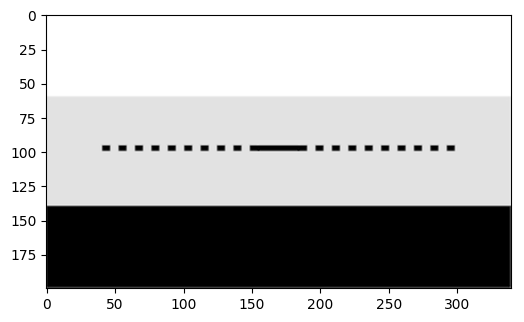

In [8]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
#                     symmetries=[mp.Mirror(mp.Y, phase=-1)],
                    progress_interval=1e6)

eps_data = show_geometry(sim)